# Bye Bye Buddy implmenting MASK R-CNN

Based on matterports MASK R-CNN demo
Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
https://github.com/matterport/Mask_RCNN

This notebook is where the main code is ran and the other external files are called. Heavily adapted from Matterports example.

These include mycustommodel, utils and PScode.

Utils and mycustommodel are adapted from matterports base code as linked above. The github is still being developled and is quite active, it's code base has changed quite a bit since the inception of my project. 

PScode is written wholly by me via the photoshop CS6 scripting guide and javascript listener.

In [1]:
import os
import sys
import random
import math
import numpy as np
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import mycustommodel as modellib


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Sets start time of program for run time analysis 
import time
start = time.time()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
# testing different models
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [2]:
# an attempt to get rid of import of coco class for further calrity 
import math
import numpy as np


# Base Configuration Class

class Config():
    
    # Primarily used for trianing but needed for classification/inference  

    NAME = None  # overwrite in sub-classes as needed
    GPU_COUNT = 1

    # Higest can be 2 for my 6gb 9gb/ps GPU
    IMAGES_PER_GPU = 2

    # used when training, default 1000
    STEPS_PER_EPOCH = 1000

    # used when training, default 50
    # Higher the more accurate but the slower
    VALIDATION_STPES = 50

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]

    # Number of classification classes (including background)
    NUM_CLASSES = 1  # overwrite in sub-classes

    ###### RPN ######
    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]

    # Anchor stride
    # If 1 then anchors are created for each cell in the backbone feature map.
    # If 2, then anchors are created for every other cell, and so on.
    RPN_ANCHOR_STRIDE = 2

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Input image resing
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    
    # If True, pad images with zeros such that they're (max_dim by max_dim)
    IMAGE_PADDING = True

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

    # Number of ROIs per image to feed to classifier/mask heads
    TRAIN_ROIS_PER_IMAGE = 128  # TODO: paper uses 512

    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Pooled ROIs
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Bounding box refinement standard deviation for RPN and final detections.
    RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
    BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

    # Learning rate and momentum
    # The paper uses lr=0.02, but we found that to cause weights to explode often
    LEARNING_RATE = 0.002
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    # Use RPN ROIs or externally generated ROIs for training
    # Set to False if you want to train the head branches on ROI 
    # generated by code rather than the ROIs from the RPN. 
    USE_RPN_ROIS = True

    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        self.IMAGE_SHAPE = np.array([self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM, 3])

        # Compute backbone size from input image size
        self.BACKBONE_SHAPES = np.array(
            [[int(math.ceil(self.IMAGE_SHAPE[0] / stride)),
              int(math.ceil(self.IMAGE_SHAPE[1] / stride))]
             for stride in self.BACKBONE_STRIDES])

    def print(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")


class CocoConfig(Config):
    # MS COCO Specific settings

    # Config name since NONE in base class
    NAME = "coco"

    # Overwrite images as needed, 1 needed if on CPU
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

## Configurations

Model trained on the MS-COCO dataset. In coco.py moved to this notebook.


In [3]:
class InferenceConfig(CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.print()

## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

HEIGHT AND WIDTH BELOW
1024
1024


## Class Names

The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
# COCO Class names Taken from model feature mapping
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Photoshop Script creation

This cell creates the Photoshop script and calls it.

In [6]:
#### ///////////////// Photoshop script 
# Cell calls photshop script from PSCode.py

# array will be array choosen
def creare_run_ps_script(padding_to_apply):
    # Photoshop base Scripts in pscode file
    import PsCode as pscode
    
    print("Image is size: ", H, "x", W, "The recommended padding for this project is:", 
          padding_to_apply, " press 0 to agree or enter desired padding")
    new_padding = input()
    if int(new_padding) != 0:
        padding_to_apply = int(new_padding)
#         print(padding_to_apply)
    
    # Calls pscode and assings name to blocks
    # Moved to keep this file more tidy
    (string_lasso_begin,string_lasso_end,content_aware_fill,add_padding,
     create_mask,deselect_mask,select_image_not_mask,mask_fill_black,
     disable_layer_mask,Try_layer_from_background) = pscode.get_ps_code(padding_to_apply)
    # print(random_string)
    
    # Emptys Phoshopscript output file 
    with open("BBBscriptOutput.jsx", 'w') as ffmask:
#         print("opened")
        ffmask.close()
        
#     print(len(mask_array))
    # Sets number of objects found for for loop
    items_found = len(mask_array)
    
    # set an index to 0 to denote start 
    mask_index = 0
    
    # this index is in for Photshop sctipt
    # starts at 3 as 1 and 2 is used to select current image
    # each action then gets assgined an action id
    # this action id is unique and as such is iterated here
    index = 3
    
    # opens script for actual wirting 
    with open("BBBscriptOutput.jsx", 'a') as fmask:
        
        # Following code pertains to the photshop script
        # Mask is an unfortunate naming coincidence and
        # a photshop mask is slighlty doffernt to masks
        # preveiosly refereneced her in a MASK R-CNN implementation
        
        # This open writes the mask slsection to file
        # this allows us to exclude all objects from the content aware fill
        
        # Sets open image to layer 0 to allow full editability
        # background layers in photoshop are locked for editing
        # so must be converted to a layer
        fmask.write(Try_layer_from_background)
        # Selects the image so that we can create mask 
        fmask.write(select_image_not_mask)
        
        # Creates Photshop mask
        fmask.write(create_mask)
        
        # Loops whilst thre are still detected objects in array
        while mask_index != items_found:
            
            # Pulls out the co-ordinates of object
            array_to_mask = mask_array[mask_index][0]
            # Writes string for the desired selection tool; lasso tool
            fmask.write(string_lasso_begin)
            
            # Loops trhough every pxiel location in array
            # they come in pairs as an X and Y co-ordinate
            # write these to Photshop scrpt as selction
            for entry in array_to_mask:
                string_to_print = pscode.pixel_selection(index,entry)
                fmask.write(string_to_print)
                index+=1
            # ends the lasso slection
            fmask.write(string_lasso_end)
            # fills the selection black so that it is excluded
            # from the content aware fill tool
            # thus ensuring no object pixels are used in 
            # the filling in of the background for deleted objects
            fmask.write(mask_fill_black)
            
            
            mask_index +=1
        
    # resets actiond id to 3 as now we work on the image itself
    # not the mask
    index = 3
    with open("BBBscriptOutput.jsx", 'a') as f:
        select_another = True
        # we now want to slect the objects on the image not the mask
        f.write(select_image_not_mask)
        # f.truncate()
        while select_another:
            
            # Numbers are displayed next to each object
            # Asks users to input number of object to be deleted
            valid_input = False
            while not valid_input:
                print("input number of object you wish to delete")
                a = input()
                print(a)
                try:
                    val = int(a)
                    if val < items_found and val > -1:
                        valid_input = True
                    
                except ValueError:
                    print("Not an integer, please enter a valid id")
                    
            # Sets array to array of objects found 
            array = mask_array[int(a)][0]
            # Selects lasso tool 
            f.write(string_lasso_begin)
            
            # Writes the selection to the Photoshop script
            for entry in array:
                string_to_print = pscode.pixel_selection(index,entry)
                f.write(string_to_print)
                index+=1
            
            # Ends selection
            f.write(string_lasso_end)
            # Applies padding to selection
            f.write(add_padding)
            # Calls content aware fill tool 
            f.write(content_aware_fill)
            
            # asks user if they would like to select
            # another object for deletion
            
            second_object_selection = False
            
            # Checks for valid input
            # Allows user to slect more then one object for deletion
            while not second_object_selection:
                print("choose another? 0 for no 1 for yes")
                b = input()
                try:
                    input_value = int(b)
                    if input_value == 0:
                        select_another = False
                        second_object_selection = True
                    if input_value == 1:
                        second_object_selection = True
                except ValueError:
                    continue
                    
                    
        # Disables thje layer mask, this is purely an aesthetic decision
        # needed to succesfully demo on demo day
        f.write(disable_layer_mask)
        f.close()
    
    # Calls script and runs it in Photoshop
    import subprocess
    import os
    
#     subprocess.call(["C:\\Program Files\\Adobe\Adobe Photoshop CS6 (64 Bit)\\Photoshop.exe", 
#                      "C:\\Users\\Paddy\\Documents\\FYP\\Mask_RCNN-master\\BBBscriptOutput.jsx"])
    # Calls photohsop at its isntall location, and calls file located in this directoy
    # runs the script in file on the current active project in photoshop
    # Photoshop should always be installed in same place
    # Scipt is created in current working directory
    subprocess.call(["C:\\Program Files\\Adobe\Adobe Photoshop CS6 (64 Bit)\\Photoshop.exe", 
                     ROOT_DIR + "\BBBscriptOutput.jsx"])

## Visualization

In this cell is where the masks and bounind boxes are applied to the image.

In [7]:
run_object_time = time.time()

import itertools
import colorsys
from skimage.measure import find_contours
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import IPython.display

# Randomly selects random colours for each mask to be displayed on the image
def random_colors(N, bright=True):
    
    # Colours generated in hsv space and converted to RGB
    # This allows us to esnure we get visually distinct colours
    # HSV sepeartes luma over RGB's chroma
    # returns colours more visually differenciating
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


# Applys mask to image with given co-ordinates
def apply_mask(image, mask, color, alpha=0.5):

    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [num_instances, height, width]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of bounding boxes
    N = boxes.shape[0]
    # Checks if any objects were found
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    # Converts to np array 
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
#         ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        # Prints labels and numbers in notebook
        # Debugging step
#         print("in visualise in notebook")
#         print(label)
#         print(score)

        caption = "{} {:.3f} {}".format(label, score,i) if score else label
        # Changes colour of text label displayed on image
#         print(caption)
#         ax.text(x1, y1 + 8, caption,
#                 color='w', size=14, backgroundcolor="none")
        ax.text(x1, y1 + 8, caption,
                color='#000000', size=14, backgroundcolor="none")

        # Mask
        # Gets detected mask and applies to image
        mask = masks[:, :, i]
#         print(mask)
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        np.set_printoptions(threshold=np.nan)

        # Work done in a previous idea for image padding
        # Replaced with a percentage of image size
#         array_of_arrays = contours[0]
#         a = array_of_arrays
#         a_min = min(i[1] for i in a)
#         import statistics
#         column_0_average = statistics.median(i[0] for i in a) 
#         column_1_average = statistics.median(i[1] for i in a)
        
#         print(column_0_average)
#         print(column_1_average)


        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            # Changes from numpy standard to Photoshop standard 
            # x,y 0,0 in a different place in each standard
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))

## Run Object Detection

This is the cell where the object detection is run.

Once model loaded in above, the image path can be changed here and this cell can use the command "Run all below", doing this will succesfully run the object detection and Photoshop script creating meaning after inital load this tool can be run on new images in a matter of seconds. 

c:\users\paddy\documents\enviroments\tensorflow_1\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


(1536, 2048, 3)
(1536,)
20.14972424507141
run object time: 4.4043495655059814


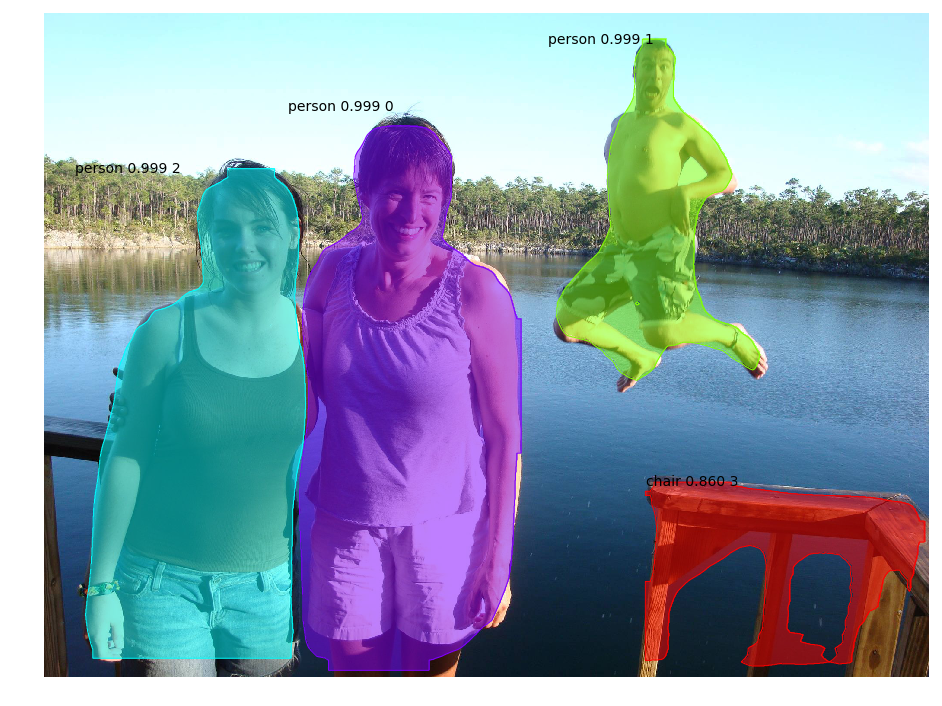

In [8]:
# Editing image here and running will allow these two cells and the majority of functionality to be run

# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]

# Select image to analyse
# This is the only place it needs to be changed to run on new image
# Long list for best Demo day results

# image = scipy.misc.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
# image = scipy.misc.imread(os.path.join(ROOT_DIR, "birdBeach.jpg"))
image = scipy.misc.imread(os.path.join(ROOT_DIR, "johnLake.jpg"))
# image = scipy.misc.imread(os.path.join(ROOT_DIR, "midEast.jpg"))
# image = scipy.misc.imread(os.path.join(ROOT_DIR, "beachWedding.jpg"))
# image = scipy.misc.imread(os.path.join(ROOT_DIR, "chrisGiraffe.jpg"))
# image = scipy.misc.imread(os.path.join(ROOT_DIR, "chrisSpire.jpg"))
# image = scipy.misc.imread(os.path.join(ROOT_DIR, "familyPhoto.jpg"))
# image = scipy.misc.imread(os.path.join(ROOT_DIR, "paddyBike.jpg")) 
# image = scipy.misc.imread(os.path.join(ROOT_DIR, "towerPisa.jpg")) 

# Image shape contains the dimensions of image
# printed for Demo day proof
# H,W,D 
print(image.shape)

# Get percentage of above and pad by that much ? 2%
print(image.shape[:1:])
# print(image.shape([1]))


# Run detection

results = model.detect([image])
# results = detect([image], verbose=1)

# Visualize results
# Prepares results of object detection for procesisng
# by mask application and Photoshop sciprting 
r = results[0]
# Gets the regions of intrest for bounding box displaying
N = r['rois'].shape[0]
# Gets masks for mask display
masks = r['masks']

# Calculate the total number of objects detected
max_num = len(masks)

mask_array = []

# Processes mask co-ordinates to corrct format
# to be diplayed on image
# Mask currectly in returned object and must be
# converted to numpy array
for i in range(N):
    mask = masks[:, :, i]
    padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    np.set_printoptions(threshold=np.nan)
#     print(contours)
    mask_array.append(contours)
        
# Calls the method above which will apply 
# lables, bounding boxes and masks to image 
display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# print(image.shape[:1:])
# print(type(image.shape[:1:]))

# H,W,D = (image.shape)
# print(type(image.shape))

# Sets height and width if image 
# Padding is calucalted using H of image
# possible implementation may be required where
# an image is far wider then it is tall
# perhpas width should be used instead
H = image.shape[0]
W = image.shape[1]
# print("below is H")
# print(H)
# print(W)
# calculates padding to apply to masks in Photoshop
# Currently settled on 2.5 of the height of an image
padding_to_apply = int(round(H / 100 * 2.5))
# print(padding_to_apply)
# print(w)

# Calculates running time of entire program
# and the object detection phas respectively 
end = time.time()
print(end - start)
print("run object time:" ,end - run_object_time )

## Call Photoshop Script Creation

This cell can be run to select other objects for deletion. it does not require detection to be run again on the image.

In [9]:
# Calls method to create Photshop sctips
# bulk of processing in this file
creare_run_ps_script(padding_to_apply)

Image is size:  1536 x 2048 The recommended padding for this project is: 38  press 0 to agree or enter desired padding
0
input number of object you wish to delete


Not an integer, please enter a valid id
input number of object you wish to delete
1
1
choose another? 0 for no 1 for yes
0
